In [4]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [5]:
# Try my matplotlib style that is read for publications.
# https://github.com/HighTemplar-wjiang/matplotlib-paperstyle
# mpl.style.use("paper")

# You can use the ggplot style for a quick start.
mpl.style.use("ggplot")

# Setting low dpi for fast plotting.
# Note to save a figure, please use the savefig() function for a good quality.  
plt.rcParams["figure.dpi"] = 50  

In [6]:
# Configurations.
datapath = "./training_data/"
outputpath = "./output_models/"

# Regular expression for data files.
file_pattern = "(?P<label>.*?)_(?P<scan_id>\d+).csv$"
re_file = re.compile(file_pattern)

In [4]:
# # Re-formatting csv files.
# def reformat_data(filepath):
#     ''' Loading a single csv file that includes spectrum data.    
#     '''
#     df_data = pd.read_csv(filepath, header=None, names=["Wavelength (nm)", "Sample Signal (unitless)", "Reflectance"])
    
#     # Calculate reference spectrum.
#     df_data["Reference"] = df_data["Sample Signal (unitless)"] / df_data["Reflectance"]
#     df_data = df_data.drop(columns=["Reflectance"])
    
#     # Write to csv.
#     df_data.to_csv(filepath, index=False, header=False)

# def reformat_files(datapath):
#     '''Loading all files. 
#     '''
#     all_files = np.array(os.listdir(datapath))
#     np.random.shuffle(all_files)
    
#     all_data = []
#     all_labels = []
#     for filename in all_files:
#         # Using regression expression to retrieve labels from the file names.
#         re_result = re_file.match(filename)
#         if re_result:
#             label = re_result["label"]
#             reformat_data(os.path.join(datapath, filename))


# # Re-formatting
# reformat_files(datapath)

In [5]:
# Loading all sample data.
def load_data(filepath):
    ''' Loading a single csv file that includes spectrum data.    
    '''
    df_data = pd.read_csv(filepath, header=None, names=["Wavelength (nm)", "Sample Signal", "Reference Signal"])
    wavelength = df_data["Wavelength (nm)"]
    
    # Getting data.
    data = df_data["Sample Signal"] / df_data["Reference Signal"]
    
    return wavelength, data

def load_files(datapath):
    '''Loading all files. 
    '''
    all_files = np.array(os.listdir(datapath))
    np.random.shuffle(all_files)
    
    all_data = []
    all_labels = []
    for filename in all_files:
        # Using regression expression to retrieve labels from the file names.
        re_result = re_file.match(filename)
        if re_result:
            label = re_result["label"]
            wavelength, data = load_data(os.path.join(datapath, filename))

            all_data += [np.array(data)]
            all_labels += [np.array(label)]
    return wavelength, all_data, all_labels

# Loading.
wavelength, all_data, all_labels = load_files(datapath)

# Conver to numpy
wavelength= np.array(wavelength)
all_data = np.array(all_data)
all_labels = np.array(all_labels)
all_categories = np.unique(all_labels)
label_counts = pd.value_counts(all_labels)

# Show number of spectra for each concentration (g/100ml).
print(label_counts.sort_index())
print("Number of data: " + str(len(all_data)))

Banana    5
Orange    5
dtype: int64
Number of data: 10


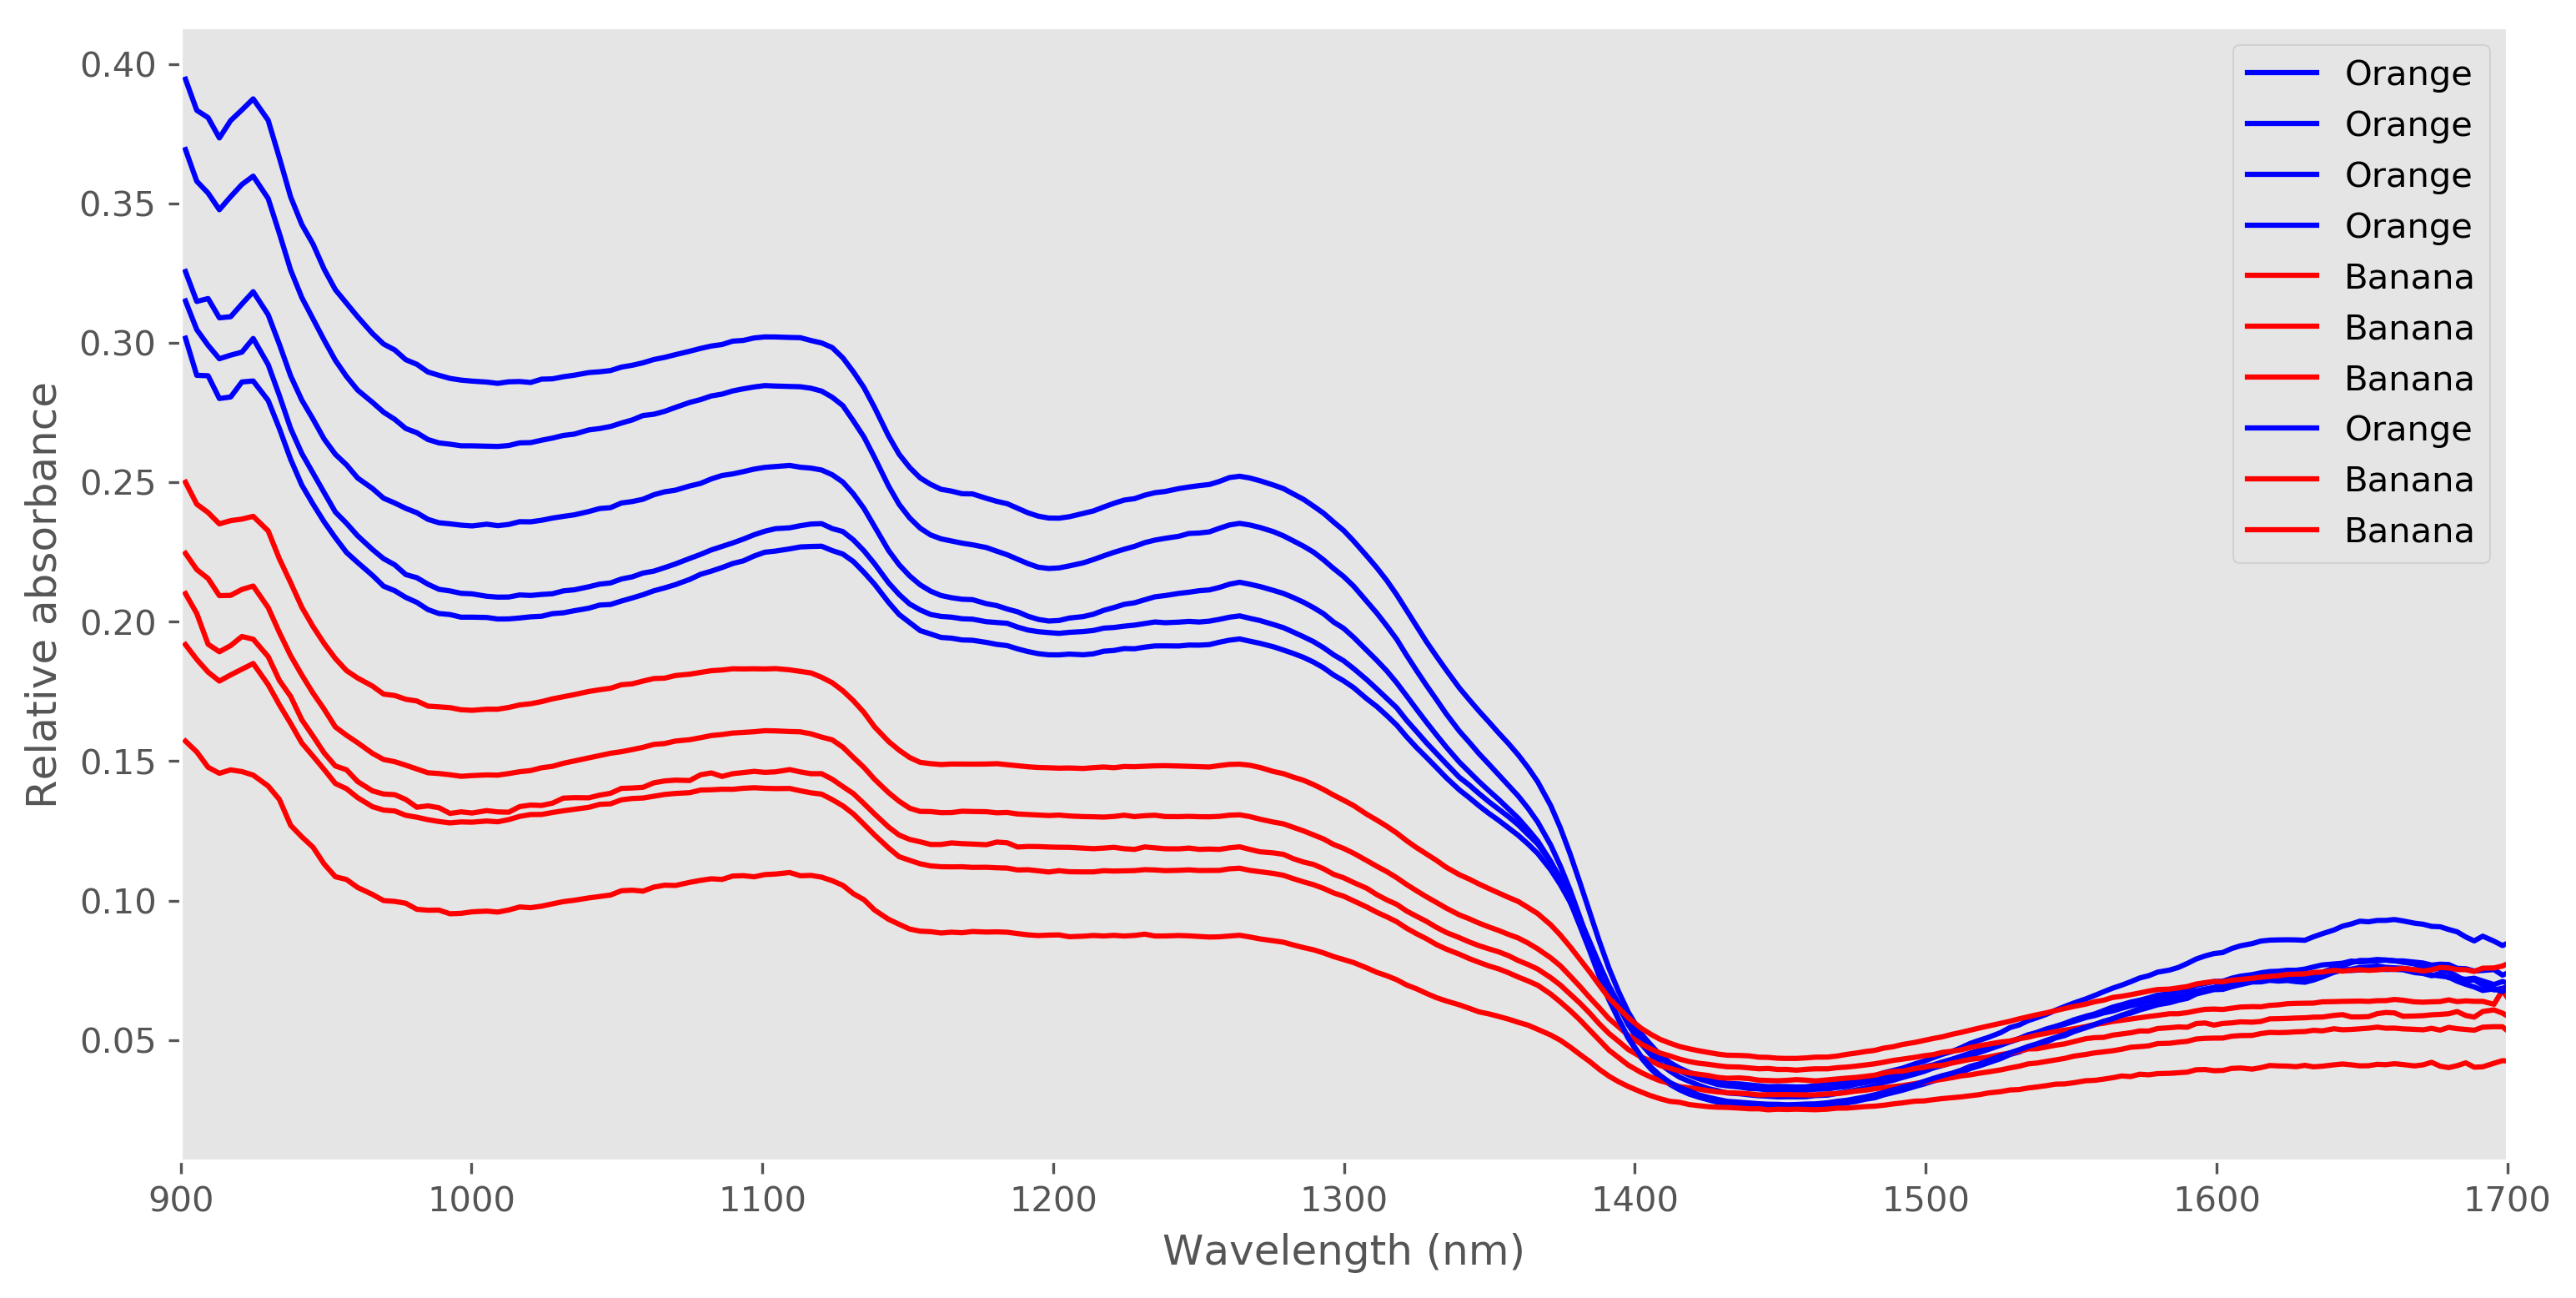

In [6]:
# Visualizing spectra. 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import TransformedBbox, BboxPatch, BboxConnector 
# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
# loc1, loc2 : {1, 2, 3, 4} 
def mark_inset(parent_axes, inset_axes, loc1a=1, loc1b=1, loc2a=2, loc2b=2, **kwargs):
    rect = TransformedBbox(inset_axes.viewLim, parent_axes.transData)

    pp = BboxPatch(rect, fill=False, **kwargs)
    parent_axes.add_patch(pp)

    p1 = BboxConnector(inset_axes.bbox, rect, loc1=loc1a, loc2=loc1b, **kwargs)
    inset_axes.add_patch(p1)
    p1.set_clip_on(False)
    p2 = BboxConnector(inset_axes.bbox, rect, loc1=loc2a, loc2=loc2b, **kwargs)
    inset_axes.add_patch(p2)
    p2.set_clip_on(False)

    return pp, p1, p2

# Visulizing.
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes

main_fontsize=16
sub_fontsize=14

# Set up the figure.
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)
ax.grid(False)
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Relative absorbance")
ax.set_xlim([900, 1700])

# Line specs and legends.
legend_lines = []
legend_strings = []
colors = list("bgrcm")

# Plotting
colors = ["r", "b", "c"]
for idx in range(all_data.shape[0]):
    # Getting color.
    idx_category = np.where(all_categories==all_labels[idx])[0][0]
    rgbs = colors[idx_category]
    
    line, = ax.plot(wavelength, all_data[idx, :], color=rgbs)
    
    # Legend.
    label = str(all_labels[idx])
#     if label not in legend_strings:
    if True:
        legend_lines += [line]
        legend_strings += [label]
ax.legend(legend_lines, legend_strings)

plt.show()

In [7]:
# Filtering.
# You can play with different filtering methods by commenting out some lines. 

import sklearn
import scipy.signal
from sklearn.preprocessing import scale



def slice_spectrum(wavelength, spectrum, start, end):
    '''Slicing the spectrum by giving start and end wavelengths.'''
    idx_start = np.argmin(abs(np.array(wavelength) - start))
    idx_end = np.argmin(abs(np.array(wavelength) - end)) + 1
    return wavelength[idx_start:idx_end], spectrum[idx_start:idx_end]

def preprocess(wavelength, datasets, labels, start_wavelength=900, end_wavelength=1700):
    '''Preprocessing spectrum.'''  
    # Processing.
    data_processed = []
    min_num = 1.
    max_num = 0.
    for idx in range(datasets.shape[0]):
        # Filtering.
        filtered = datasets[(idx), :]
#         filtered = scipy.signal.savgol_filter(filtered, window_length=11, polyorder=3)
#         filtered = np.log(1/filtered) / 10
#         filtered = np.gradient(filtered) # First-order gradient
#         filtered = np.gradient(filtered) # Second-order gradient
        filtered = scipy.signal.savgol_filter(filtered, window_length=21, polyorder=3)
#         filtered = np.gradient(filtered) # Third-order gradient
#         filtered = filtered / np.sum(filtered)
#         filtered = scale(np.transpose(filtered), with_mean=True, with_std=False)
        wavelength_sub, filtered = slice_spectrum(wavelength, filtered, start_wavelength, end_wavelength)
        data_processed.append(filtered)
    
    return data_processed

# Processing.
all_data_processed = preprocess(wavelength, all_data, all_labels)

# Converting to numpy array.
all_data_processed = np.array(all_data_processed)
print(all_data_processed.shape)

(10, 228)


/anaconda3/envs/data/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [7]:
# Training models.
import time
import joblib
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier 

# Creating models.
svc_model = SVC(C=100., gamma=0.5, kernel=u'rbf', tol=0.1, probability=True)
rfc_model = RandomForestClassifier(n_estimators=20, warm_start=True)
sgd_model = SGDClassifier(warm_start=True)

all_models = [svc_model, rfc_model, sgd_model]
all_model_names = ["SVC", "RFC", "SGD"]
model_dict = dict((all_model_names[idx], all_models[idx]) for idx in range(len(all_models)))

# Save un-trained models.
for model_name, model in zip(all_model_names, all_models):
    with open(os.path.join(outputpath, "untrained/" + model_name), "wb") as f:
        joblib.dump({"model": model,
                     "classes": []}, f)

In [9]:
# Spliting train / test data.
from copy import deepcopy

train_data = []
train_labels = []
test_data = []
test_labels = []


# Splitting.
total_number = np.min(label_counts)
train_number = int(total_number * 0.8)
test_number = total_number - train_number
for category in all_categories:
    indexes = np.where(all_labels == category)[0]

    # For splitting-and-test
    train_indexes = indexes[:train_number]
    test_indexes = indexes[train_number:train_number+test_number]

    print(category)
    print("Train: {} \n Test: {}".format(str(train_indexes), str(test_indexes)))
    # Split data.
    train_data += [all_data_processed[int(idx), :] for idx in train_indexes]
    train_labels += [all_labels[int(idx)] for idx in train_indexes]
    test_data += [all_data_processed[int(idx), :] for idx in test_indexes]
    test_labels += [all_labels[int(idx)] for idx in test_indexes]

train_data = np.array(train_data)
train_labels = np.array(train_labels)
test_data = np.array(test_data)
test_labels = np.array(test_labels)

print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

Banana
Train: [4 5 6 8] 
 Test: [9]
Orange
Train: [0 1 2 3] 
 Test: [7]
(8, 228)
(8,)
(2, 228)
(2,)


In [10]:
# Training.
# Run multiple times for testing.
import joblib
from sklearn.metrics import r2_score, mean_squared_error

# Training.
for model_name, model in zip(all_model_names, all_models):
    print("\n" + model_name, end=":")
    train_acc = []
    test_acc = []
    for idx_train in range(1):
        
        # Training.
        model.fit(train_data, train_labels)
        predictions = model.predict(train_data)
        
        # Train acc.
        train_acc.append(model.score(train_data, train_labels))
        
        # Test acc.
        test_acc.append(model.score(test_data, test_labels))
        
        # Export models.
        model_path = os.path.join(outputpath, "trained/{}".format(model_name))
        print(model_path)
        with open(model_path, "wb") as f:
            joblib.dump({"model": model, 
                         "classes": model.classes_.tolist()}, f)

    print("\nTrain: {}".format(np.mean(train_acc)))
    print("Test:  {}".format(np.mean(test_acc)))


SVC:./output_models/trained/SVC

Train: 1.0
Test:  1.0

RFC:./output_models/trained/RFC

Train: 1.0
Test:  1.0

SGD:./output_models/trained/SGD

Train: 1.0
Test:  0.5


/anaconda3/envs/data/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
